## License 

Copyright 2017 Patrick Hall and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Engineering Transparency into Your Machine Learning Model with Python and XGBoost
#### Monotonic XGBoost models, partial dependence, ICE, and Shapley explanations

A key to building interpretable models is to limit their complexity. The more complex a model is, the harder it is to explain and understand. Overly complex models can also make unstable predictions on new data, which is both difficult to explain and makes models harder to trust. Monotonicity constraints not only simplify models, but do so in a way that is somewhat natural for human reasoning, increasing the transparency of predictive models. Under monotonicity constraints, model predictions can only increase or only decrease as an input variable value increases, and the direction of the constraint is typically specified by the user for logical reasons. For instance, a model might be constrained to produce only increasing probabilities of a certain medical condition as a patient's age increases, or to make only increasing predictions for home prices as a home's square footage increases. 

In this notebook a gradient boosting machine (GBM) is trained with monotonicity constraints to predict credit card payment defaults, using the UCI credit card default data, Python, NumPy, Pandas, and XGBoost. First, the credit card default data is loaded and prepared. Then Pearson correlation with the prediction target is used to determine the direction of the monotonicity constraints for each input variable and the model is trained. After the model is trained, partial dependence and individual conditional expectation (ICE) plots are used to analyze and verify the model's monotonic behavior. Finally an example of creating regulator mandated reason codes from high fidelity Shapley explanations for any model prediction is presented. This combination of monotonic XGBoost, partial dependence, ICE, and Shapley explanations is probably the most direct way to create an interpretable machine learning model today.

#### Python imports 

Let's start with Python package imports. NumPy is used for basic arrray, vector, and matrix calculations. Pandas is used for data frame manipulation and plotting, and XGBoost is used to train a GBM with monotonicity constraints.

In [1]:
import numpy as np                   # array, vector, matrix calculations
import pandas as pd                  # DataFrame handling
import xgboost as xgb                # gradient boosting machines (GBMs)

import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of plots in notebook
%matplotlib inline              

## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005. Because XGBoost accepts only numeric inputs, all variables will be treated as numeric.

#### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`. 

In [2]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input variables in the credit card default data except the row indentifier, `ID`.

In [3]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Display descriptive statistics
The Pandas `describe()` function displays a brief description of the credit card default data. The input variables `SEX`, `EDUCATION`, `MARRIAGE`, `PAY_0`-`PAY_6`, and the prediction target `DEFAULT_NEXT_MONTH`, are really categorical variables, but they have already been encoded into meaningful numeric, integer values, which is great for XGBoost. Also, there are no missing values in this dataset.

In [4]:
data[X + [y]].describe() # display descriptive statistics for all columns

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## 2. Investigate pair-wise Pearson correlations for DEFAULT_NEXT_MONTH

Monotonic relationships are much easier to explain to colleagues, bosses, customers, and regulators than more complex, non-monotonic relationships and monotonic relationships may also prevent overfitting and excess error due to variance for new data.

To train a transparent monotonic classifier, contraints must be supplied to XGBoost that determine whether the learned relationship between an input variable and the prediction target `DEFAULT_NEXT_MONTH` will be increasing for increases in an input variable or decreasing for increases in an input variable. Pearson correlation provides a linear measure of the direction of the relationship between each input variable and the target. If the pair-wise Pearson correlation between an input and `DEFAULT_NEXT_MONTH` is positive, it will be constrained to have an increasing relationship with the predictions for `DEFAULT_NEXT_MONTH`. If the pair-wise Pearson correlation is negative, the input will be constrained to have a decreasing relationship with the predictions for `DEFAULT_NEXT_MONTH`. 

Constrainsts are supplied to XGBoost in the form of a Python tuple with length equal to the number of inputs. Each item in the tuple is associated with an input variable based on its index in the tuple. The first constraint in the tuple is associated with the first variable in the training data, the second constraint in the tuple is associated with the second variable in the training data, and so on. The constraints themselves take the form of a 1 for a positive relationship and a -1 for a negative relationship.

#### Calculate Pearson correlation

The Pandas `.corr()` function returns the pair-wise Pearson correlation between variables in a Pandas DataFrame. Because `DEFAULT_NEXT_MONTH` is the last column in the `data` DataFrame, the last column of the Pearson correlation matrix indicates the direction of the linear relationship between each input variable and the prediction target, `DEFAULT_NEXT_MONTH`. According to the calculated values, as a customer's balance limit (`LIMIT_BAL`), bill amounts (`BILL_AMT1`-`BILL_AMT6`), and payment amounts (`PAY_AMT1`-`PAY_AMT6`) increase, their probability of default tends to decrease. However as a customer's number of late payments increase (`PAY_0`, `PAY_2`-`PAY6`), their probability of default usually increases. In general, the Pearson correlation values make sense, and they will be used to ensure that the modeled relationships will make sense as well. (Pearson correlation values between the target variable, DEFAULT_NEXT_MONTH, and each input variable are displayed directly below.)

In [5]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1] 

,DEFAULT_NEXT_MONTH
LIMIT_BAL,-0.153520
SEX,-0.039961
EDUCATION,0.028006
MARRIAGE,-0.024339
AGE,0.013890
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149


#### Create tuple of monotonicity constraints from Pearson correlation values

The last column of the Pearson correlation matrix is transformed from a numeric column in a Pandas DataFrame into a Python tuple of `1`s and `-1`s that will be used to specifiy monotonicity constraints for each input variable in XGBoost. If the Pearson correlation between an input variable and `DEFAULT_NEXT_MONTH` is positive, a positive montonic relationship constraint is specified for that variable using `1`. If the correlation is negative, a negative monotonic constraint is specified using `-1`. (Specifying `0` indicates that no constraints should be used.) The resulting tuple will be passed to XGBoost when the GBM model is trained.

In [6]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(data[X + [y]].corr()[y].values[:-1])])

# (-1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)

## 3. Train XGBoost with monotonicity constraints

XGBoost is a very accurate, open source GBM library for regression and classification tasks. XGBoost can learn complex relationships between input variables and a target variable, but here the `monotone_constraints` tuning parameter is used to enforce monotonicity between inputs and the prediction for `DEFAULT_NEXT_MONTH`. XGBoost's early stopping functionality is also used to limit overfitting to the training data

XGBoost is available from: https://github.com/dmlc/xgboost and the implementation of XGBoost is described in detail here: http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf.

After training, GBM variable importance is calculated and displayed. GBM variable importance is a global measure of the overall impact of an input variable on the GBM model predictions. Global variable importance values give an indication of the magnitude of a variable's contribution to model predictions for all observations. To enhance trust in the GBM model, variable importance values should typically conform to human domain knowledge and reasonable expectations.

#### Split data into training and test sets for early stopping

The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is another important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [7]:
np.random.seed(12345) # set random seed for reproducibility
split_ratio = 0.7     # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 25
Test data rows = 9054, columns = 25


#### Train XGBoost GBM classifier
To train an XGBoost classifier, the training and test data must be converted from Pandas DataFrames into SVMLight format. The `DMatrix()` function in the XGBoost package is used to convert the data. Many XGBoost tuning parameters must be specified as well. Typically a grid search would be performed to identify the best parameters for a given modeling task. For brevity's sake, a previously-discovered set of good tuning parameters are specified here. Notice that the monotonicity constraints are passed to XGBoost using the `monotone_constraints` parameter. Because gradient boosting methods typically resample training data, an additional random seed is also specified for XGBoost using the `seed` paramter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `early_stopping_rounds` parameter is used to stop the training process after the test area under the curve (AUC) statistic fails to increase for 50 iterations.

In [8]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

# used to calibrate predictions to mean of y 
base_y = train[y].mean()

# tuning parameters
params = {
    'objective': 'binary:logistic',             # produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        # base learner will be decision tree
    'eval_metric': 'auc',                       # stop training based on maximum AUC, AUC always between 0-1
    'eta': 0.08,                                # learning rate
    'subsample': 0.9,                           # use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    # use 90% of columns in each decision tree
    'max_depth': 15,                            # allow decision trees to grow to depth of 15
    'monotone_constraints':mono_constraints,    # 1 = increasing relationship, -1 = decreasing relationship
    'base_score': base_y,                       # calibrate predictions to mean of y 
    'seed': 12345                               # set random seed for reproducibility
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# train model
xgb_model = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain,                   # training data
                      1000,                     # maximum of 1000 iterations (trees)
                      evals=watchlist,          # use watchlist for early stopping 
                      early_stopping_rounds=50, # stop after 50 iterations (trees) without increase in AUC
                      verbose_eval=True)        # display iteration progress


[0]	train-auc:0.738066	eval-auc:0.733449
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.772991	eval-auc:0.769311
[2]	train-auc:0.775536	eval-auc:0.772624
[3]	train-auc:0.776248	eval-auc:0.771985
[4]	train-auc:0.777216	eval-auc:0.772796
[5]	train-auc:0.777782	eval-auc:0.773066
[6]	train-auc:0.777783	eval-auc:0.773471
[7]	train-auc:0.777856	eval-auc:0.773591
[8]	train-auc:0.777633	eval-auc:0.773209
[9]	train-auc:0.777417	eval-auc:0.772892
[10]	train-auc:0.777519	eval-auc:0.772666
[11]	train-auc:0.778476	eval-auc:0.773346
[12]	train-auc:0.778541	eval-auc:0.773312
[13]	train-auc:0.778351	eval-auc:0.773266
[14]	train-auc:0.778519	eval-auc:0.773695
[15]	train-auc:0.779383	eval-auc:0.774314
[16]	train-auc:0.779555	eval-auc:0.77473
[17]	train-auc:0.780178	eval-auc:0.775043
[18]	train-auc:0.780743	eval-auc:0.775246
[19]	train-auc:0.78146	eval-auc:0.776021
[20]	train-auc:0.781944	eval-au

####  Display variable importance
The variable importance ranking should be parsimonious with human domain knowledge and reasonable expectations. In this case, `LIMIT_BAL` is by far the most important variable. As credit limits are a tool used to price risk into lending decisions, this result appears valid.   

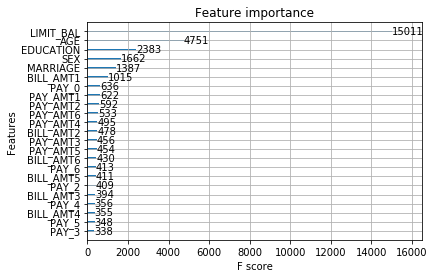

In [9]:
# plot variable importance bar chart
_ = xgb.plot_importance(xgb_model)

## 4. Calculating partial dependence and ICE to validate and explain monotonic behavior

Partial dependence plots are used to view the global, average prediction behavior of a variable under the monotonic model. Partial dependence plots show the average prediction of the monotonic model as a function of specific values of an input variable of interest, indicating how the monotonic GBM predictions change based on the values of the input variable of interest, while taking nonlinearity into consideration and averaging out the effects of all other
input variables. Partial dependence plots enable increased transparency into the monotonic GBM's mechanisms and enable validation and debugging of the monotonic GBM by comparing a variable's average predictions across its domain to known standards and reasonable expectations. Partial dependence plots are described in greater detail in *The Elements of Statistical Learning*, section 10.13: https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf.

Individual conditional expectation (ICE) plots, a newer and less well-known adaptation of partial dependence plots, can be used to create more localized explanations for a single observation of data using the same basic ideas as partial dependence plots. ICE is also a type of nonlinear sensitivity analysis in which the model predictions for a single observation are measured while a feature of interest is varied over its domain. ICE increases understanding and transparency by displaying the nonlinear behavior of the monotonic GBM. ICE also enhances trust, accountability, and fairness by enabling comparisons of nonlinear behavior to human domain knowledge and reasonable expectations. ICE, as a type of sensitivity analysis, can also engender trust when model behavior on simulated or extreme data points is acceptable. A detailed description of ICE is available in this arXiv preprint: https://arxiv.org/abs/1309.6392.

Because partial dependence and ICE are measured on the same scale, they can be displayed in the same line plot to compare the global, average prediction behavior for the entire model and the local prediction behavior for certain rows of data.

#### Function for calculating partial dependence
Since partial dependence and ICE will be calculated for several important variables in the GBM model, it's convenient to have a function doing so. It's probably best to analyze partial dependence and ICE for all variables in a model, but only the top three most important input variables will be investigated here. It's also a good idea to analyze partial dependence and ICE on the test data, or other holdout datasets, to see how the model will perform on new data. 
This simple function is designed to return partial dependence when it is called for an entire dataset and ICE when it is called for a single row. The `bins` argument will be used later to calculate ICE values at the same places in an input variable domain that partial dependence is calculated directly below. 

In [10]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame


#### Calculate partial dependence for the most important input variables in the GBM
The partial dependence for `LIMIT_BAL` can be seen to decrease as credit balance limits increase. This finding is aligned with expectations that the model predictions will be monotonically decreasing with increasing `LIMIT_BAL` and parsimonious with well-known business practices in credit lending. Partial dependence for other important values is displayed in plots further below.

In [11]:
par_dep_LIMIT_BAL = par_dep('LIMIT_BAL', test[X], xgb_model) # calculate partial dependence for LIMIT_BAL
par_dep_AGE = par_dep('AGE', test[X], xgb_model)             # calculate partial dependence for AGE
par_dep_EDUCATION = par_dep('EDUCATION', test[X], xgb_model) # calculate partial dependence for EDUCATION

# display partial dependence for LIMIT_BAL
par_dep_LIMIT_BAL

,LIMIT_BAL,partial_dependence
0,10000.0,0.279759
1,59500.0,0.242470
2,109000.0,0.223919
3,158500.0,0.216145
4,208000.0,0.213525
5,257500.0,0.207870
6,307000.0,0.204860
7,356500.0,0.196379
8,406000.0,0.194843
9,455500.0,0.194028


#### Helper function for finding percentiles of predictions

ICE can be calculated for any row in the training or test data, but without intimate knowledge of a data source it can be difficult to know where to apply ICE. Calculating and analyzing ICE curves for every row of training and test data set can be overwhelming, even for the example credit card default dataset. One place to start with ICE is to calculate ICE curves at every decile of predicted probabilities in a dataset, giving an indication of local prediction behavior across the dataset. The function below finds and returns the row indices for the maximum, minimum, and deciles of one column in terms of another -- in this case, the model predictions (`p_DEFAULT_NEXT_MONTH`) and the row identifier (`ID`), respectively. 

In [12]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict


#### Find some percentiles of yhat in the test data
The values for `ID` that correspond to the maximum, minimum, and deciles of `p_DEFAULT_NEXT_MONTH` are displayed below. ICE will be calculated for the rows of the test dataset associated with these `ID` values.

In [13]:
# merge GBM predictions onto test data
yhat_test = pd.concat([test.reset_index(drop=True), pd.DataFrame(xgb_model.predict(dtest))], axis=1)
yhat_test = yhat_test.rename(columns={0:'p_DEFAULT_NEXT_MONTH'})

# find percentiles of predictions
percentile_dict = get_percentile_dict('p_DEFAULT_NEXT_MONTH', 'ID', yhat_test)

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
percentile_dict

{0: 23477,
 10: 16339,
 20: 11924,
 30: 7711,
 40: 2941,
 50: 367,
 60: 21027,
 70: 14844,
 80: 15491,
 90: 27719,
 99: 17757}

#### Calculate ICE curve values
ICE values represent a model's prediction for a row of data while an input variable of interest is varied across its domain. The values of the input variable are chosen to match the values at which partial dependence was calculated earlier, and ICE is calculated for the top three most important variables and for rows at each percentile of the test dataset. 

In [14]:
# retreive bins from original partial dependence calculation
bins_LIMIT_BAL = list(par_dep_LIMIT_BAL['LIMIT_BAL'])
bins_AGE = list(par_dep_AGE['AGE'])
bins_EDUCATION = list(par_dep_EDUCATION['EDUCATION'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest
for i in sorted(percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for LIMIT_BAL across percentiles at bins_LIMIT_BAL intervals
    par_dep_LIMIT_BAL[col_name] = par_dep('LIMIT_BAL', 
                                          test[test['ID'] == int(percentile_dict[i])][X], 
                                          xgb_model, 
                                          bins=bins_LIMIT_BAL)['partial_dependence']
    
    # ICE curves for AGE across percentiles at bins_AGE intervals
    par_dep_AGE[col_name] = par_dep('AGE', 
                                    test[test['ID'] == int(percentile_dict[i])][X],  
                                    xgb_model, 
                                    bins=bins_AGE)['partial_dependence']

    # ICE curves for EDUCATION across percentiles at bins_EDUCATION intervals
    par_dep_EDUCATION[col_name] = par_dep('EDUCATION', 
                                          test[test['ID'] == int(percentile_dict[i])][X],  
                                          xgb_model, 
                                          bins=bins_EDUCATION)['partial_dependence']
    

#### Display partial dependence and ICE for `LIMIT_BAL`
Partial dependence and ICE values for rows at the minimum, maximum and deciles (0%, 10%, 20%, ..., 90%, 99%) of predictions for `DEFAULT_NEXT_MONTH` and at the values of `LIMIT_BAL` used for partial dependence are shown here. Each column of ICE values will be a curve in the plots below. ICE values represent a prediction for a row of test data, at a percentile of interest noted in the column name above, and setting `LIMIT_BAL` to the value of `LIMIT_BAL` at right. Notice that monotonic decreasing prediction behavior for `LIMIT_BAL` holds at each displayed percentile of predicted `DEFAULT_NEXT_MONTH`, helping to validate that the trained GBM predictions are monotonic for `LIMIT_BAL`.

In [15]:
par_dep_LIMIT_BAL

,LIMIT_BAL,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,10000.0,0.279759,0.005558,0.113869,0.118038,0.170604,0.168605,0.169341,0.267717,0.321920,0.361774,0.608842,0.972647
1,59500.0,0.242470,0.004279,0.099108,0.109122,0.157985,0.123984,0.151342,0.181595,0.236824,0.299376,0.599501,0.947990
2,109000.0,0.223919,0.002484,0.081224,0.090135,0.125151,0.095719,0.115535,0.148451,0.236824,0.284345,0.595503,0.944482
3,158500.0,0.216145,0.001930,0.071003,0.082292,0.099942,0.078613,0.102603,0.132566,0.236824,0.266300,0.594121,0.944270
4,208000.0,0.213525,0.001727,0.070660,0.079553,0.097273,0.075463,0.101664,0.119960,0.236824,0.259052,0.591674,0.943386
5,257500.0,0.207870,0.001559,0.069117,0.073050,0.090227,0.070042,0.099865,0.116429,0.236705,0.253781,0.573963,0.941485
6,307000.0,0.204860,0.001505,0.067185,0.071985,0.088302,0.068640,0.095907,0.115167,0.236681,0.248429,0.570151,0.940316
7,356500.0,0.196379,0.000995,0.058246,0.056453,0.078762,0.059234,0.082871,0.091302,0.234665,0.229563,0.562227,0.939820
8,406000.0,0.194843,0.000987,0.057939,0.054967,0.076855,0.058440,0.082404,0.090903,0.234396,0.227753,0.557926,0.939109
9,455500.0,0.194028,0.000987,0.056633,0.053490,0.076662,0.057292,0.080833,0.089335,0.233668,0.227412,0.557913,0.938999


## 5. Plotting partial dependence and ICE to validate and explain monotonic behavior

Overlaying partial dependence onto ICE in a plot is a convenient way to validate and understand both global and local monotonic behavior. Plots of partial dependence curves overlayed onto ICE curves for several percentiles of predictions for `DEFAULT_NEXT_MONTH` are used to validate monotonic behavior, describe the GBM model mechanisms, and to compare the most extreme GBM behavior with the average GBM behavior in the test data. Partial dependence and ICE plots are displayed for the three most important variables in the GBM: `LIMIT_BAL`, `AGE`, and `EDUCATION`.

#### Function to plot partial dependence and ICE

In [16]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


#### Partial dependence and ICE plot for `LIMIT_BAL`
The monotonic prediction behavior displayed in the partial dependence, and ICE tables for `LIMIT_BAL` is also visible in this plot. Monotonic decreasing behavior is evident at every percentile of predictions for `DEFAULT_NEXT_MONTH`. Most percentiles of predictions show that sharper decreases in probability of default occur when `LIMIT_BAL` increases just slightly from its lowest values in the test set. However, for the custumers that are most likely to default according to the GBM model, no increase in `LIMIT_BAL` has a strong impact on probabilitiy of default. As mentioned previously, the displayed relationship between credit balance limits and probablility of default is not uncommon in credit lending.

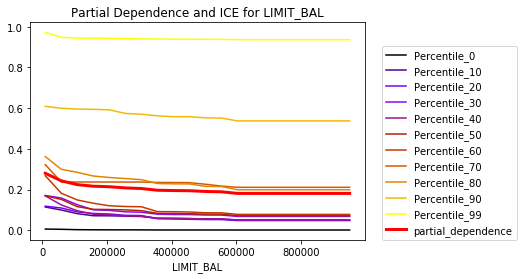

In [17]:
plot_par_dep_ICE('LIMIT_BAL', par_dep_LIMIT_BAL) # plot partial dependence and ICE for LIMIT_BAL

#### Partial dependence and ICE plot for `AGE`
Monotonic increasing prediction behavior for `AGE` is displayed for all percentiles of model predictions. Predition behavior is different at different deciles, but not abnormal or vastly different from the average prediction behavior represented by the red partial dependence curve, except for the customer most likely to default. For this high-risk customer, changes in AGE do not have a large impact on their probability of default. 

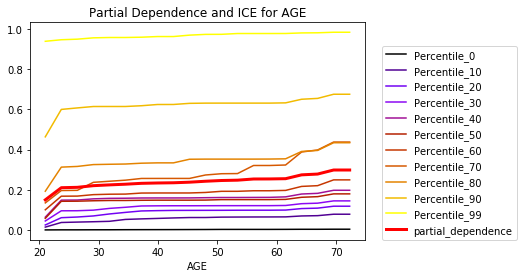

In [18]:
plot_par_dep_ICE('AGE', par_dep_AGE) # plot partial dependence and ICE for AGE

#### Partial dependence and ICE plot for `EDUCATION`
Monotonic increasing prediction behavior for `EDUCATION` is also displayed for all percentiles. This mild increase in probability of default as education increases could be related to more educated customers taking on more debt than less educated customers. 

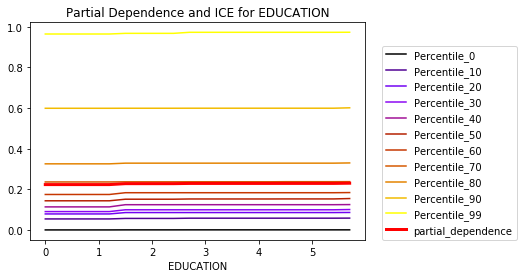

In [19]:
plot_par_dep_ICE('EDUCATION', par_dep_EDUCATION) # plot partial dependence and ICE for EDUCATION

## 6. Generate reason codes using the Shapley method 
Now that the monotonic behavior of the GBM has been verified and compared against domain knowledge and reasonable expectations, a method called Shapley explanations will be used to calculate the local variable importance for any one prediction: http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions. Shapley explanations are the only possible consistent local variable importance values. (Here consistency means that if a variable is more important than another variable in a given prediction, the more important variable's Shapley value will not be smaller in magnitude than the less important variable's Shapley value.) Very crucially Shapley values also *always* sum to the actual prediction of the XGBoost model. When used in a model-specific context for decision tree models, Shapley values are likely the most accurate known local variable importance method available today. In this notebook, XGBoost itself is used to create Shapley values with the `pred_contribs` parameter to `predict()`, but the `shap` package is also available for other types of models: https://github.com/slundberg/shap. 

The numeric Shapley values in each column are an estimate of how much each variable contributed to each prediction. Shapley contributions can indicate how a variable and its values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are related to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders in the U.S. must provide reasons for automatically rejecting a credit application. Reason codes can be easily extracted from Shapley local variable contribution values by ranking the variables that played the largest role in any given decision.

#### Calculate local variable importance for each row of the test set. 
By setting `pred_contribs=True`, XGBoost's `predict()` function will return Shapley values for each row of the test set. 

In [20]:
# dtest is DMatrix
# shap_values is Numpy array
shap_values = xgb_model.predict(dtest, pred_contribs=True)

To find the index corresponding to a particular row of interest later, the index of the `test` DataFrame is reset to begin at 0 and increase sequentially. Without resetting the index, the `test` DataFrame row indices still correspond to the original raw data from which the test set was sampled.

In [21]:
test.reset_index(drop=True, inplace=True)

#### Select most risky customer in test data
One person who might be of immediate interest is the most likely to default customer in the test data. This customer's row will be selected and local variable importance for the corresponding prediction will be analyzed.

In [22]:
decile = 99
row = test[test['ID'] == percentile_dict[decile]]

#### Create a Pandas DataFrame of Shapley values for riskiest customer
The most interesting Shapley values are probably those that push this customer's probability of default higher, i.e. the highest positive Shapley values. Those values are plotted below.

In [23]:
# reset test data index to find riskiest customer in shap_values 
# sort to find largest positive contributions
s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(23, 1), columns=['Reason Codes'], index=X)
s_df.sort_values(by='Reason Codes', inplace=True, ascending=False)

#### Plot top local contributions as reason codes

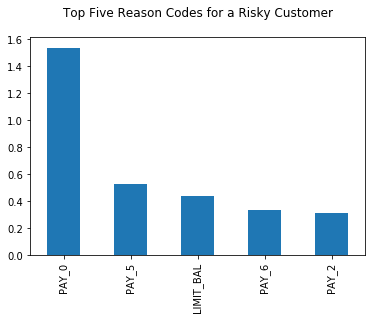

In [24]:
_ = s_df[:5].plot(kind='bar', 
                  title='Top Five Reason Codes for a Risky Customer\n', 
                  legend=False)

For the customer in the test dataset that the GBM predicts as most likely to default, the most important input variables in the prediction are, in descending order, `PAY_0`, `PAY_5`, `LIMIT_BAL`, `PAY_6`, and `PAY_2`.

#### Display customer in question 

The local contributions for this customer appear reasonable, especially when considering her payment information. Her most recent payment was 3 months late and her payment for 6 months and 5 months previous were 7 months late. Also her credit limit was extremely low, so it's logical that these factors would weigh heavily into the model's prediction for default for this customer.

In [29]:
row # helps understand reason codes

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
5399,17757,10000,2,3,1,51,3,2,2,7,7,7,2400,2400,2400,2400,2400,2400,0,0,0,0,0,0,1


#### Summary

In this notebook, a highly transparent, nonlinear, monotonic GBM classifier was trained to predict credit card defaults and the monotonic behavior of the classifier was analyzed and validated. To do so, Pearson correlation between each input and the target was used to determine the direction for monotonicity constraints for each input variable in the XGBoost classifier. GBM variable importance, partial dependence, and ICE were calculated, plotted, and compared to one another, domain knowledge, and reasonable expectations. Shapley values were then used to explain the model predictions for the single most risky customer in the test set. These techniques should generalize well for many types of business and research problems, enabling you to train a monotonic GBM model and analyze, validate, and explain it to your colleagues, bosses, and potentially, external regulators. 